# Template for the usage of the project

Small example on basis of the first task to show the usage and test/debug the project.

## Environment Setup



In [1]:
import os
from pathlib import Path as P

import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import ruamel.yaml
yaml = ruamel.yaml.YAML()

import optuna

# Import project
import experiments
import models
import src
import utils


###--- Jupyter Environment Parameter ---###
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CONFIG_PATH = None

EXPERIMENT_NAME = 'template'
RUN_NAME = 'test_01'

WRITE_LOGS = False # Log data that is produced withing the notebook

# Set required environment variables
os.environ['EXP_DIRECTORY'] = str((P(os.getcwd())) / "experiments") # Assumes notebook is run from the base directory
os.environ['ACTIVATE_EXP'] = EXPERIMENT_NAME
os.environ['ACTIVE_RUN'] = RUN_NAME


## Hyperparameters

In [2]:
###--- Model Configuration ---###
MODEL_CONFIG = {
                        'run_name' : 'test',
                        'model' : 'mlp',
                        'num_epochs' : 30,
                        'num_iterations': 0,       # 0 indicates that in each epoch the complete dataset is traversed. This value should be overwritter in code.
                        'dataset': {
                                'name': 'svhn',
                                'train_size': 73257,
                                'val_size': 6000,
                                'test_size': 26032,
                                'train_shuffle': True,
                                'eval_shuffle': False,
                                'drop_last': True,
                                'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],   # Has to be defined prior to training from the dataset meta information.
                        },
                        'batch_size' : 32,
                        'loss': {
                                'type': 'CrossEntropy'
                        },
                        'eval_batch_size': 32,
                        'eval_frequency' : 5,
                        'pre_processing': {
                                'flatten': True,
                                'flatten_only_img_size': True,
                                'rgb2gray': True,
                                'lbl_oneHot': True,
                                'squeeze': True
                        },
                        'layers': [
                                {
                                'type': 'linear',
                                'dimension': 518,
                                'activation': 'relu'
                                },
                                {
                                'type': 'linear',
                                'dimension': 128,
                                'activation': 'relu'
                                },
                                {
                                'type': 'linear',
                                'dimension': 64,
                                'activation': 'relu'
                                },
                                {
                                'type': 'linear',
                                'dimension': 32,
                                'activation': 'relu'
                                },
                                {
                                'type': 'linear',
                                'dimension': 10,
                                'activation': 'softmax'
                                }

                        ],
                        'input_dim': 1024,
                        'output_dim': 10,
                        'optimizer': {
                                'type': 'Adam',
                                'learning_rate': 0.0002,
                                'betas': [0.9, 0.99],
                                'eps': 0.00000001
                        },
                        'evaluation': {
                                'metrics': ['accuracy']
                        },
                        'save_frequency': 5,
                        'random_seed': 42,
                        'verbosity_level': 1    
                        }

    
###--- Hyperparameter Optimization Configuration ---###
OPTIMIZATION_CONFIG = {}



## Setup Experiment

In [3]:
# Initialize a run to create a directory to save all results
ret = experiments.initiate_run(EXPERIMENT_NAME, MODEL_CONFIG, RUN_NAME)

Run directory already exists. Caution, existing files might be overwritten!


## Data Loading ###

Load data and print example images.

In [4]:
if MODEL_CONFIG['dataset']['name'] == 'svhn':
    train_dataset, test_dataset = utils.load_svhn_dataset()
elif MODEL_CONFIG['dataset']['name'] == 'mnist':
    train_dataset, test_dataset = utils.load_mnist_dataset()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=MODEL_CONFIG['batch_size'], shuffle=MODEL_CONFIG['dataset']['train_shuffle'], drop_last=MODEL_CONFIG['dataset']['drop_last'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=MODEL_CONFIG['eval_batch_size'], shuffle=MODEL_CONFIG['dataset']['eval_shuffle'], drop_last=MODEL_CONFIG['dataset']['drop_last'])

print('\n')
print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Using downloaded and verified file: ./data/svhn/train_32x32.mat
Using downloaded and verified file: ./data/svhn/test_32x32.mat


Train dataset size: 73257
Test dataset size: 26032


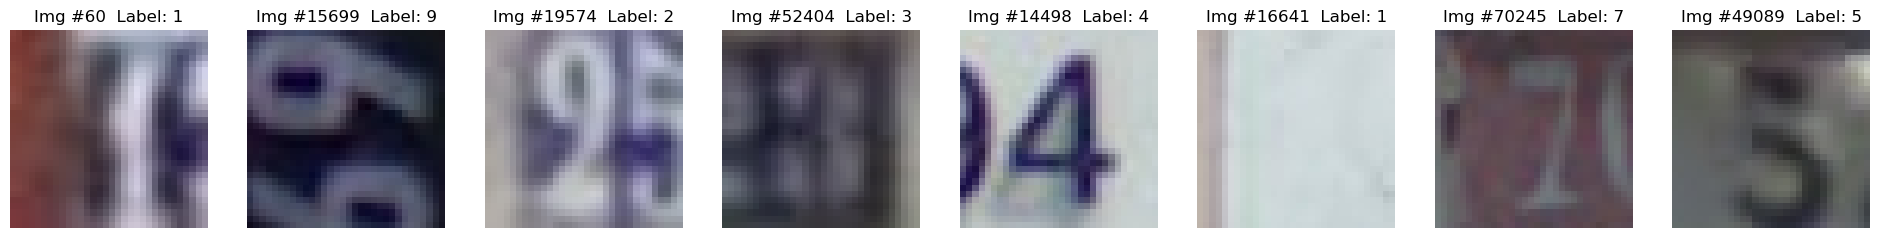

In [5]:
###--- Visualize Training Images ---###

NUM_IMG = 8

fig, ax = plt.subplots(1,NUM_IMG)
fig.set_size_inches(3 * NUM_IMG, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=NUM_IMG)

for i, n in enumerate(ids):
    img = train_dataset[n][0].permute(1,2,0)
    label = train_dataset[n][1]
    ax[i].imshow(img)
    ax[i].set_title(f"Img #{n}  Label: {label}")
    ax[i].axis("off")


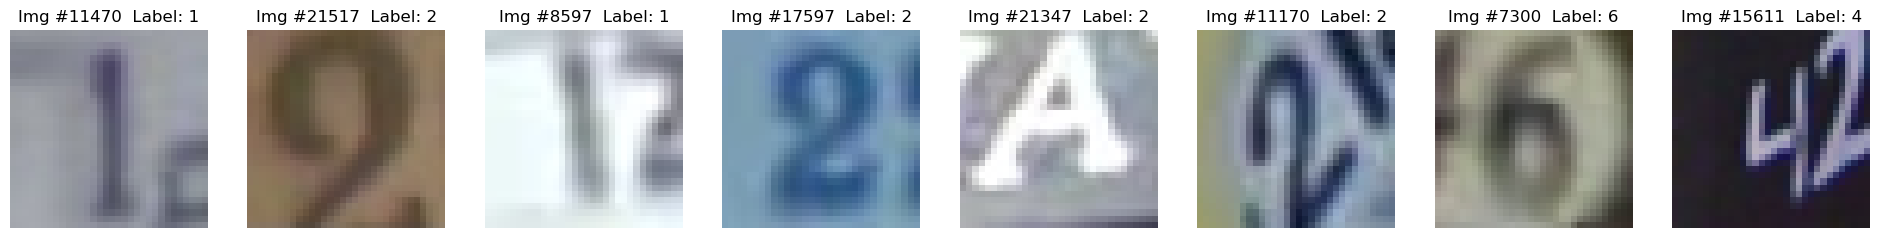

In [6]:
###--- Visualize Evaluation Images ---###

NUM_IMG = 8

fig, ax = plt.subplots(1,NUM_IMG)
fig.set_size_inches(3 * NUM_IMG, 3)

ids = np.random.randint(low=0, high=len(test_dataset), size=NUM_IMG)

for i, n in enumerate(ids):
    img = test_dataset[n][0].permute(1,2,0)
    label = test_dataset[n][1]
    ax[i].imshow(img)
    ax[i].set_title(f"Img #{n}  Label: {label}")
    ax[i].axis("off")

## Training





### Model Configuration

In [7]:
###--- Training Parameters ---###

CONFIG_PATH = None
# Load configuration from an existing run
LOAD_CONFIG = False

if LOAD_CONFIG:
    EXP_NAME_CONFIG = 'template'
    RUN_NAME_CONFIG = 'test_01'

    MODEL_CONFIG = experiments.load_cofig(EXP_NAME_CONFIG, RUN_NAME_CONFIG)
    

if CONFIG_PATH is not None:
    MODEL_CONFIG = yaml.load(CONFIG_PATH)

### Define Model from the config

In [8]:
# Load model
if MODEL_CONFIG['model'] == 'mlp':
    model = models.load_mlp_model(MODEL_CONFIG)

model = model.to(DEVICE)

# Load criterion for loss computation
criterion = src.initialize_loss(MODEL_CONFIG['loss'])

# Load optimizer
optimizer = src.initialize_optimizer(model, MODEL_CONFIG['optimizer'])



In [9]:
# Initialize logger to get training and evaluation results
logger = experiments.Logger(
                exp_name = EXPERIMENT_NAME,
                run_name = RUN_NAME,
                model_config = MODEL_CONFIG,
                anon_mode = not WRITE_LOGS, # Whether to write to logs outside of notebook
)

# Initialize logger to log the training
logger.init_training()

# Print logger configuration for debugging
logger._print_logger_config()

Run environement not completely specified. Logger running in anonymous mode --> No logging to disk.
Logger was initialized for training.
 <----Logger Configuration---->
  Log Gradients: False
  Log Data: True
  Checkpoint Frequency: 0
  Verbose: False
  Log Gradients: False
  Log Data: True
  Checkpoint Frequency: 5
  Anonymous Mode: True
  Disabled: False
  Verbose: False
  Current Logger State:
    Log ID: test_01_0000
    Training: True
    Evaluation: False
    Tuning: False
    Epoch: 0
    Iteration: 0

 --Model Configuration--
  run_name: test
  model: mlp
  num_epochs: 30
  num_iterations: 0
  dataset: {'name': 'svhn', 'train_size': 73257, 'val_size': 6000, 'test_size': 26032, 'train_shuffle': True, 'eval_shuffle': False, 'drop_last': True, 'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}
  batch_size: 32
  loss: {'type': 'CrossEntropy'}
  eval_batch_size: 32
  eval_frequency: 5
  pre_processing: {'flatten': True, 'flatten_only_img_size': True, 'rgb2gray': True, 'lbl_oneHot': True, '

### Train Model


In [10]:
# Train the model, all results are saved withing the logger and can be retrieved when needed.

# Initialize logger to log the training
logger.init_training()

src.train_model_01(
                model = model,
                train_dataset = train_loader,
                eval_dataset = test_loader,
                optimizer = optimizer,
                criterion = criterion,
                config = MODEL_CONFIG,
                logger = logger
)

# Finish logging of training automatically initializes logging of evaluation.
logger.finish()

src.run_evaluation(
                model = model,
                dataset = test_loader,
                logger = logger
)

# Finish logging of evaluation. All results we are interested in are saved withing the logger and can be retrieved when needed.
logger.finish()

CalledProcessError: Command 'b'\n# Train the model, all results are saved withing the logger and can be retrieved when needed.\n\n# Initialize logger to log the training\nlogger.init_training()\n\nsrc.train_model_01(\n                model = model,\n                train_dataset = train_loader,\n                eval_dataset = test_loader,\n                optimizer = optimizer,\n                criterion = criterion,\n                config = MODEL_CONFIG,\n                logger = logger\n)\n\n# Finish logging of training automatically initializes logging of evaluation.\nlogger.finish()\n\nsrc.run_evaluation(\n                model = model,\n                dataset = test_loader,\n                logger = logger\n)\n\n# Finish logging of evaluation. All results we are interested in are saved withing the logger and can be retrieved when needed.\nlogger.finish()\n'' returned non-zero exit status 1.

## Ablation Studies

Test out different configurations of the model to find the best performing and show impact of different hyperparameters on the performance.
We utilize the hyperparameter optimization framework optuna to find the best setting for a pre-defined set of parameters.

### Model Architecture
First explore different model architectures. To see the effect of different configurations and find the right architecture to further optimize

In [11]:
#   Since we first want to explore the performance of different architectures, 
#   we give the hyperparameter tuner a fixed set of architectures it should explore rather than letting him optimize a single architecture w.r.t. number of layers and neurons per layer

### Model Architectures ###
featureExt_arch_1 = [
                        {
                        'type': 'linear',
                        'dimension': 518,
                        'activation': 'relu'
                        },
                        {
                        'type': 'linear',
                        'dimension': 128,
                        'activation': 'relu'
                        },
                        {
                        'type': 'linear',
                        'dimension': 64,
                        'activation': 'relu'
                        },
                        {
                        'type': 'linear',
                        'dimension': 32,
                        'activation': 'relu'
                        },
                        {
                        'type': 'linear',
                        'dimension': 10,
                        'activation': 'softmax'
                        }

                    ]

featureExt_arch_2 = [
                        {
                        'type': 'linear',
                        'dimension': 518,
                        'activation': 'relu'
                        },
                        {
                        'type': 'linear',
                        'dimension': 64,
                        'activation': 'relu'
                        },
                        {
                        'type': 'linear',
                        'dimension': 32,
                        'activation': 'relu'
                        },
                        {
                        'type': 'linear',
                        'dimension': 10,
                        'activation': 'softmax'
                        }

                    ]

featureExt_arch_2 = [
                        {
                        'type': 'linear',
                        'dimension': 518,
                        'activation': 'relu'
                        },
                        {
                        'type': 'linear',
                        'dimension': 128,
                        'activation': 'relu'
                        },
                        {
                        'type': 'linear',
                        'dimension': 64,
                        'activation': 'relu'
                        },
                        {
                        'type': 'linear',
                        'dimension': 10,
                        'activation': 'softmax'
                        }

                    ]

flat_arch_1 =   [
                        {
                        'type': 'linear',
                        'dimension': 256,
                        'activation': 'relu'
                        },
                        {
                        'type': 'linear',
                        'dimension': 256,
                        'activation': 'relu'
                        },
                        {
                        'type': 'linear',
                        'dimension': 256,
                        'activation': 'relu'
                        },
                        {
                        'type': 'linear',
                        'dimension': 10,
                        'activation': 'softmax'
                        }

                ]

flat_arch_2 =   [
                        {
                        'type': 'linear',
                        'dimension': 256,
                        'activation': 'relu'
                        },
                        {
                        'type': 'linear',
                        'dimension': 256,
                        'activation': 'relu'
                        },
                        {
                        'type': 'linear',
                        'dimension': 10,
                        'activation': 'softmax'
                        }

                ]

flat_arch_3 =   [
                        {
                        'type': 'linear',
                        'dimension': 128,
                        'activation': 'relu'
                        },
                        {
                        'type': 'linear',
                        'dimension': 128,
                        'activation': 'relu'
                        },
                        {
                        'type': 'linear',
                        'dimension': 128,
                        'activation': 'relu'
                        },
                        {
                        'type': 'linear',
                        'dimension': 10,
                        'activation': 'softmax'
                        }

                ]

dropout_arch_1 =  [
                        {
                        'type': 'linear',
                        'dimension': 128,
                        'activation': 'relu'
                        },
                        {
                        'type': 'dropout',
                        'prob': 0.5
                        },
                        {
                        'type': 'linear',
                        'dimension': 128,
                        'activation': 'relu'
                        },
                        {
                        'type': 'dropout',
                        'prob': 0.5
                        },
                        {
                        'type': 'linear',
                        'dimension': 10,
                        'activation': 'softmax'
                        }

                    ]

architectures = [featureExt_arch_1, featureExt_arch_2, flat_arch_1, flat_arch_2, flat_arch_3, dropout_arch_1]

In [12]:
OPTIMIZATION_CONFIG = {
                        'parameter':    [{   'param': 'layers',
                                            'type': 'categorical',
                                            'range': architectures}],
                        'n_trials': len(architectures),
                        'eval_metric': 'accuracy',
                        'sampler': 'TPESampler',
                        'pruner': 'MedianPruner',
                        'maximize': True
}

MODEL_CONFIG['num_iterations'] = MODEL_CONFIG['dataset']['train_size'] // MODEL_CONFIG['batch_size'] 
MODEL_CONFIG['num_iterations'] += 0 if MODEL_CONFIG['dataset']['drop_last'] else 1


tune_logger = src.Logger(
                    exp_name=EXPERIMENT_NAME, 
                    run_name=RUN_NAME, 
                    model_config=MODEL_CONFIG,
                    verbose=False,
                    log_gradients=False,
                    log_data = True,
    )

src.optimize_model_01(config=MODEL_CONFIG, logger=logger, optimization_config=OPTIMIZATION_CONFIG, verbose=True)




[I 2023-04-24 14:04:00,095] A new study created in memory with name: no-name-e2503c43-cf33-4e07-b51e-1bc9949a5480


Logging enabled for Hyperparameter tuning
-----Start Hyperparameter Tuning-----

  Number of Trials in pipeline: 1

  Start optimization...

 ---Trial 1 of 1---
   Trial configuration:

   parameter : [{'param': 'layers', 'type': 'categorical', 'range': [[{'type': 'linear', 'dimension': 518, 'activation': 'relu'}, {'type': 'linear', 'dimension': 128, 'activation': 'relu'}, {'type': 'linear', 'dimension': 64, 'activation': 'relu'}, {'type': 'linear', 'dimension': 32, 'activation': 'relu'}, {'type': 'linear', 'dimension': 10, 'activation': 'softmax'}], [{'type': 'linear', 'dimension': 518, 'activation': 'relu'}, {'type': 'linear', 'dimension': 128, 'activation': 'relu'}, {'type': 'linear', 'dimension': 64, 'activation': 'relu'}, {'type': 'linear', 'dimension': 10, 'activation': 'softmax'}], [{'type': 'linear', 'dimension': 256, 'activation': 'relu'}, {'type': 'linear', 'dimension': 256, 'activation': 'relu'}, {'type': 'linear', 'dimension': 256, 'activation': 'relu'}, {'type': 'linear', 

/home/user/denninge/anaconda3/envs/vision_lab/lib/python3.9/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [{'type': 'linear', 'dimension': 518, 'activation': 'relu'}, {'type': 'linear', 'dimension': 128, 'activation': 'relu'}, {'type': 'linear', 'dimension': 64, 'activation': 'relu'}, {'type': 'linear', 'dimension': 32, 'activation': 'relu'}, {'type': 'linear', 'dimension': 10, 'activation': 'softmax'}] which is of type list.
  warnings.warn(message)
/home/user/denninge/anaconda3/envs/vision_lab/lib/python3.9/site-packages/optuna/distributions.py:535: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [{'type': 'linear', 'dimension': 518, 'activation': 'relu'}, {'type': 'linear', 'dimension': 128, 'activation': 'relu'}, {'type': 'linear', 'dimension': 64, 'activat

Using downloaded and verified file: ./data/svhn/extra_32x32.mat
Using downloaded and verified file: ./data/svhn/test_32x32.mat


Evaluation::  91%|█████████ | 740/813 [00:03<00:00, 238.95it/s]
[W 2023-04-24 14:05:13,404] Trial 0 failed with parameters: {'layers': [{'type': 'linear', 'dimension': 256, 'activation': 'relu'}, {'type': 'linear', 'dimension': 256, 'activation': 'relu'}, {'type': 'linear', 'dimension': 10, 'activation': 'softmax'}]} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/user/denninge/anaconda3/envs/vision_lab/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/home/user/denninge/projects/VisionLabSS23/src/tuning.py", line 184, in objective
    score = self._train_evaluate_model(
  File "/home/user/denninge/projects/VisionLabSS23/src/tuning.py", line 284, in _train_evaluate_model
    eval_score_epoch.append(list(run_evaluation(model=model, dataset=test_loader, config=self.config_optimized).values())[0][0])
  File "/home/user/denninge/projects/VisionLabSS23/src/evaluatio

KeyboardInterrupt: 